# Set Up / Data Cleaning

In [1]:
import pandas as pd

file_path = r"C:\Users\rruiz\Desktop\claims.xlsx"

claims = pd.read_excel(file_path)

print(claims.head())

            ClaimID CLM_THRU_DT CLM_FROM_DT  CLM_TYPE_CD Claim_Category  \
0  1091076100076860  2022-12-22  2022-12-08           60         Part A   
1  1745301100301820  2023-08-04  2023-08-02           60         Part A   
2  1660307100307270  2023-07-01  2023-06-24           60         Part A   
3  1763043100043860  2023-07-17  2023-07-01           60         Part A   
4  2182780100780190  2023-12-02  2023-11-22           60         Part A   

   CLM_LINE_DGNS_CD BETOS_Code_Description Procedure_Description  \
0               NaN                Unknown               Unknown   
1               NaN                Unknown               Unknown   
2               NaN                Unknown               Unknown   
3               NaN                Unknown               Unknown   
4               NaN                Unknown               Unknown   

            Claim_Type_w_ED  Facility_Provider_NPI_Number  facility_ZIP  \
0  Medicare Inpatient Claim                    1598773715        

In Excel,
- Removed members with only 1 claim (never discharged/readmitted)
- Removed claims from members not in eligible list
- Removed claims whose end date was after member's eligibility/active period

# Question 1:
What's the 30-day readmission rate for patients who were discharged to a SNF in 2023? (Define discharge to a SNF as any SNF stay that begins 3 or fewer days after a discharge.)


- Discharged patient: A patient who starts a SNF claim within 3 days after the end date of an inpatient claim

- Readmitted patient: A patient who starts an inpatient claim 30 days after the end date of a SNF claim

In [2]:
# Count discharged patients

# SNF claims condition
snf_claims_condition = (claims['Claim_Type_w_ED'] == 'Medicare Non-Swing Bed Skilled Nursing Facility (SNF) Claim')

# Inpatient claims condition
inpatient_claims_condition = (claims['Claim_Type_w_ED'] == 'Medicare Inpatient Claim')

# Extract SNF claims and inpatient claims
snf_claims = claims.loc[snf_claims_condition, ['mbi', 'CLM_FROM_DT']]
inpatient_claims = claims.loc[inpatient_claims_condition, ['mbi', 'CLM_THRU_DT']]

# Merge SNF and inpatient claims on 'mbi'
merged_claims = pd.merge(snf_claims, inpatient_claims, on='mbi', how='inner')

# Calculate the time difference between SNF claim start date and inpatient claim end date
merged_claims['time_diff'] = (pd.to_datetime(merged_claims['CLM_FROM_DT']) - pd.to_datetime(merged_claims['CLM_THRU_DT'])).dt.days

# Filter for cases where the time difference is 3 days or less
filtered_claims = merged_claims[merged_claims['time_diff'] <= 3]

# Count the number of distinct patients with SNF claims following inpatient claims by 3 days or less
discharged_patients = filtered_claims['mbi'].nunique()

print(f"Discharged patients: {discharged_patients}")


Discharged patients: 485


In [3]:
# Count readmitted patients

# Calculate the time difference between SNF claim end date and inpatient claim start date
merged_claims['time_diff'] = (pd.to_datetime(merged_claims['CLM_THRU_DT']) - pd.to_datetime(merged_claims['CLM_FROM_DT'])).dt.days

# Filter for cases where the time difference is 30 days
filtered_claims = merged_claims[merged_claims['time_diff'] == 30]

# Count the number of distinct members with inpatient claims starting 30 days after SNF claims end
readmitted_patients = filtered_claims['mbi'].nunique()

print(f"Readmitted patients: {readmitted_patients}")


Readmitted patients: 13


In [4]:
## Calculate readmission rate

readmission_rate = round(readmitted_patients / discharged_patients * 100, 2)
print(f"Readmission rate: {readmission_rate}%")


Readmission rate: 2.68%


# Question 2
What's the average length of stay at SNFs for patients who were discharged from a SNF in 2023? 


- Calculate the average duration between the start and end dates of SNF claims for discharged patients.

In [ ]:
# SNF claims condition
snf_claims_condition = (claims['Claim_Type_w_ED'] == 'Medicare Non-Swing Bed Skilled Nursing Facility (SNF) Claim')

# Inpatient claims condition
inpatient_claims_condition = (claims['Claim_Type_w_ED'] == 'Medicare Inpatient Claim')

# Extract SNF claims and inpatient claims
snf_claims = claims.loc[snf_claims_condition, ['mbi', 'CLM_FROM_DT', 'CLM_THRU_DT']]
inpatient_claims = claims.loc[inpatient_claims_condition, ['mbi', 'CLM_THRU_DT']]

# Merge SNF and inpatient claims on 'mbi'
merged_claims = pd.merge(snf_claims, inpatient_claims, on='mbi', how='inner')

# Calculate the time difference between SNF claim start date and inpatient claim end date
merged_claims['time_diff'] = (pd.to_datetime(merged_claims['CLM_FROM_DT']) - pd.to_datetime(merged_claims['CLM_THRU_DT_y'])).dt.days

# Filter for cases where the time difference is 3 days or less
filtered_claims = merged_claims[merged_claims['time_diff'] <= 3]

# Calculate the length of SNF claims
filtered_claims['snf_claim_length'] = (pd.to_datetime(filtered_claims['CLM_THRU_DT_x']) - pd.to_datetime(filtered_claims['CLM_FROM_DT'])).dt.days

# Calculate the average length of SNF claims
avg_snf_claim_length = filtered_claims['snf_claim_length'].mean()


In [6]:
print(f"Average Length of Stay in SNF: {avg_snf_claim_length:.2f} days")

Average Length of Stay in SNF: 17.30 days


# Question 3
Make a visualization looking at inpatient admissions trends for our providers in 2023.

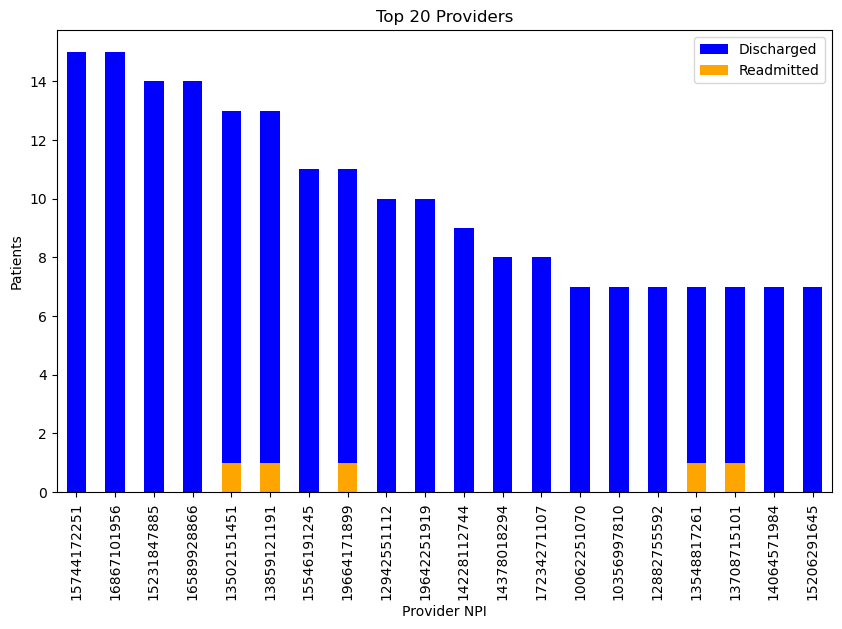

In [7]:
import matplotlib.pyplot as plt

# SNF claims condition
snf_claims_condition = (claims['Claim_Type_w_ED'] == 'Medicare Non-Swing Bed Skilled Nursing Facility (SNF) Claim')

# Inpatient claims condition
inpatient_claims_condition = (claims['Claim_Type_w_ED'] == 'Medicare Inpatient Claim')

# Extract SNF claims and inpatient claims
snf_claims = claims.loc[snf_claims_condition, ['mbi', 'CLM_FROM_DT', 'CLM_THRU_DT', 'pcp_npi']]
inpatient_claims = claims.loc[inpatient_claims_condition, ['mbi', 'CLM_THRU_DT', 'pcp_npi']]

# Merge SNF and inpatient claims on 'mbi'
merged_claims = pd.merge(snf_claims, inpatient_claims, on=['mbi', 'pcp_npi'], how='inner')

# Calculate the time difference between SNF claim start date and inpatient claim end date
merged_claims['time_diff'] = (pd.to_datetime(merged_claims['CLM_FROM_DT']) - pd.to_datetime(merged_claims['CLM_THRU_DT_y'])).dt.days

# Filter for cases where the time difference is 3 days or less
filtered_claims = merged_claims[merged_claims['time_diff'] <= 3]

# Count the number of discharged patients per provider
discharged_per_provider = filtered_claims.groupby('pcp_npi')['mbi'].nunique()

# Filter for cases where the time difference is 30 days
readmitted_claims = merged_claims[merged_claims['time_diff'] == 30]

# Count the number of distinct members with inpatient claims starting 30 days after SNF claims end
readmitted_per_provider = readmitted_claims.groupby('pcp_npi')['mbi'].nunique()

# Get the top 20 providers
top_20_providers_discharged = discharged_per_provider.nlargest(20)
top_20_providers_readmitted = readmitted_per_provider.reindex(top_20_providers_discharged.index, fill_value=0)

# Plot the bar chart with rotated x-axis labels
fig, ax = plt.subplots(figsize=(10, 6))
top_20_providers_discharged.plot(kind='bar', ax=ax, color='blue', label='Discharged')
top_20_providers_readmitted.plot(kind='bar', ax=ax, color='orange', label='Readmitted')
plt.title('Top 20 Providers')
plt.xlabel('Provider NPI')
plt.ylabel('Patients')
plt.legend()
plt.show()


- Use visualization to monitor top providers, minimize readmissions, and prioritize value-based care.